In [3]:
import jax 
from typing import Callable 
import numpy as np 

import jax.numpy as jnp 
from jaxtyping import Array , Float , Int , PRNGKeyArray
import apebench

import matplotlib.pyplot as plt 
import seaborn as sns
from flax import nnx

/home/aries/fine_tunning/venv/lib/python3.12/site-packages/trainax/_general_trainer.py:7: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
advection_scenario = apebench.scenarios.difficulty.Advection()

In [3]:
train_data = advection_scenario.get_train_data()
train_data.shape

(50, 51, 1, 160)

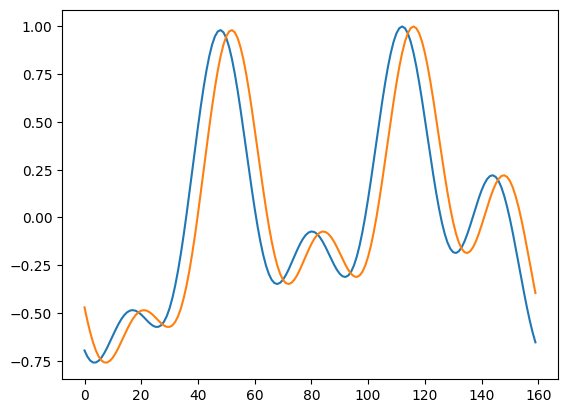

In [4]:
plt.plot(train_data[2 , :2 , 0 , : ].T)


# Understanding the Advection Scenario Data

## Data Structure

The `train_data` variable contains a 4-dimensional array representing advection simulations:

- **Dimension 0**: Multiple simulation samples (time steps or different scenarios)
- **Dimension 1**: Time evolution or additional temporal dimension
- **Dimension 2**: Single feature channel
- **Dimension 3**: 160 spatial points (continuous seats in the stadium analogy)

## Stadium Analogy

Imagine a stadium with **160 continuous seats** representing spatial points. 

we are measuring how loud each person is 1 Feature

we measure loudness each second for 51 seconds straight 

we perform this experiment 50 time

## Data Characteristics

- **Data Type**: Float32 (32-bit floating point numbers)
- **Value Range**: Approximately -1.0 to 1.0 (normalized values)
- **Pattern**: Shows smooth spatial gradients typical of advection phenomena, where values propagate along the spatial domain

This is typical of a physics-based simulation where a wave or concentration profile flows through space according to advection dynamics.


**What we want to learn is that given the blue state from the graph predict the orange state while tending over the spacial domain**

$$
\mathrm{Attention}(Q, K, V)
=
\operatorname{softmax}
\left(
\frac{QK^{T}}{\sqrt{d_k}}
\right)
V
$$

In [5]:
def scaled_dot_product_attention(
      query: Float[Array, "seq_len key_size"],
      key : Float[Array , "seq_len key_size"],
      value : Float[Array , "seq_len value_size"]
)-> Float[Array , "seq_len value_size"]:
    """ No masking"""

    key_size = query.shape[-1]
    attn_logits :Float[Array, "seq_len seq_len"]= (query @ key.T) / jnp.sqrt(key_size)
    attn_weights :Float[Array , " seq_len seq_len"] = jax.nn.softmax(attn_logits , axis = -1)

    results : Float[Array , "seq_len value_size"] = attn_weights @ value
    return results

query - (seq_len , key_size) - sequence_lenght follwed by key size - imagine a 2D matrix in which each word can be represented using a unique key of equal size and stack all of these words togther

key - same as query 

value - same as query

$$
\mathrm{MultiHead}(Q, K, V)
=
\mathrm{Concat}(\mathrm{head}_1, \dots, \mathrm{head}_h)\, W^O
$$

$$
\mathrm{where}\quad
\mathrm{head}_i
=
\mathrm{Attention}(Q W_i^Q,\; K W_i^K,\; V W_i^V)
$$

In [6]:
class MultiHeadAttention(nnx.Module):
    nums_head : int 
    query_proj : nnx.Linear
    key_proj : nnx.Linear
    value_proj : nnx.Linear
    output_proj : nnx.Linear

    def __init__(self ,num_heads : int , embed_shape : int ,*,  rngs : nnx.Rngs):
        (query_proj_key , key_proj_key , value_proj_key , output_proj_key) = jax.random.split(rngs)

        self.output_proj = nnx.Linear(in_features = embed_shape , out_features = embed_shape  , rngs = output_proj_key)  
        self.query_proj = nnx.Linear(in_features = embed_shape , out_features = embed_shape  , rngs = query_proj_key)
        self.key_proj = nnx.Linear(in_features = embed_shape , out_features = embed_shape , rngs = key_proj_key)
        self.value_proj = nnx.Linear(in_features = embed_shape , out_features = embed_shape , rngs = value_proj_key)
        self.nums_head = num_heads

    def __call__(self  , x :Float[Array , "seq_len emb_dims"]) -> Float[Array , "seq_len emb_dims"]:
        seq_len , emb_dims = x.shape
        query = self.query_proj(x)
        key = self.key_proj(x)
        value = self.value_proj(x)

        #reshape 
        query = query.reshape(seq_len, self.nums_head, emb_dims // self.nums_head)
        key = key.reshape( seq_len ,self.nums_head , emb_dims // self.nums_head)
        value = value.reshape( seq_len ,self.nums_head , emb_dims // self.nums_head)

        query = query.traspose(1, 0 , 2 )
        key = key.transpose(1, 0, 2)
        value = value.transpose(1 , 0,  2)

        result = scaled_dot_product_attention(query ,key , value)

        result = result.reshape((seq_len, emb_dims))
        result = result.transpose(1, 0, 2)

        # bug that i found if the emebeding are not divisible by num head than it means that it cannot be divided equally
        #
        assert emb_dims % self.nums_head ==0 

        output = self.output_proj(result)

In [ ]:
class MLP(nnx.Module):
    hidden_dims : int 
    output_dims : int 

    def __init__(self , input_dims : int , output_dims:int, hidden_dims: int = 256 , * , rngs : nnx.Rngs ):
        layer1_key , layer2_key  = jax.random.split(rngs , 2)
        self.layer1 = nnx.Linear(in_features = input_dims , out_features=hidden_dims , rngs = layer1_key)
        self.layer2 = nnx.Linear(in_features=hidden_dims , out_features=output_dims , rngs = layer2_key)

    def __call__(self , x):
        x = self.layer1(x)
        x = nnx.relu(x)
        x = self.layer2(x)

        return x
    

In [11]:
class TransformerBlock(nnx.Module):
    mha : MultiHeadAttention
    mlp :  MLP
    norm1 : nnx.LayerNorm
    norm2 : nnx.LayerNorm


    def __init__(self,
                 num_heads : int,
                 emb_dims : int, 
                 mlp_channels_multiplier : int = 2,
                 activation : Callable = nnx.relu,
                 *,
                 key = PRNGKeyArray):
        mha_key , mlp_key  = jax.random.split(key , 2)
        self.mha = MultiHeadAttention(num_heads , emb_dims , rngs = mha_key)
        self.mlp = MLP(input_dims=emb_dims , output_dims=emb_dims ,rngs= mlp_key)
        self.norm1 = nnx.LayerNorm(emb_dims,)
        self.norm2 = nnx.LayerNorm(emb_dims)

    def __call__(self , 
                 x : Float[Array , "seq_len embed_dims"]
                 ) -> Float[Array , "seq_len embed_dims"]:
        
        x = self.norm1(self.mha(x) + x)
        x = self.norm2(self.mlp(x) + x)

        return x





## Poistional Embeddings
$$
\mathrm{PE}(pos, i) =
\begin{cases}
\sin\!\left(\dfrac{pos}{10000^{\frac{i}{d_{\text{model}}}}}\right), & \text{if } i \bmod 2 = 0 \\[10pt]
\cos\!\left(\dfrac{pos}{10000^{\frac{i-1}{d_{\text{model}}}}}\right), & \text{if } i \bmod 2 = 1
\end{cases}
$$

In [ ]:
def get_postions( seq_lenght : int , emb_dims : int ) :
    postions = jnp.arange(seq_lenght)
    postions.reshape(-1 , 1)

    dims = jnp.arange(dims)
    dims.reshape(1 , -1)

    angle = postions / pow(1000 , (2*(dims // 2)) / emb_dims)


[0 1 2 3 4 5 6 7 8 9]


In [ ]:
# pos = 1 
# emd_dims = 64

# pos_emb = get_postions(pos , emd_dims)
# print(pos_emb)

[8.4147102e-01 6.4790589e-01 6.8156135e-01 7.9645789e-01 5.3316844e-01
 8.8375598e-01 4.0930894e-01 9.3406159e-01 3.1098360e-01 9.6273899e-01
 2.3492108e-01 9.7898918e-01 1.7689219e-01 9.8816657e-01 1.3295726e-01
 9.9333978e-01 9.9833421e-02 9.9625289e-01 7.4919157e-02 9.9789226e-01
 5.6204498e-02 9.9881452e-01 4.2157151e-02 9.9933332e-01 3.1617504e-02
 9.9962509e-01 2.3711516e-02 9.9978918e-01 1.7781857e-02 9.9988145e-01
 1.3334819e-02 9.9993330e-01 9.9998331e-03 9.9996251e-01 7.4988720e-03
 9.9997890e-01 5.6233834e-03 9.9998814e-01 4.2169522e-03 9.9999332e-01
 3.1622723e-03 9.9999624e-01 2.3713715e-03 9.9999791e-01 1.7782785e-03
 9.9999881e-01 1.3335211e-03 9.9999934e-01 9.9999993e-04 9.9999964e-01
 7.4989413e-04 9.9999976e-01 5.6234124e-04 9.9999988e-01 4.2169652e-04
 9.9999994e-01 3.1622776e-04 9.9999994e-01 2.3713737e-04 1.0000000e+00
 1.7782794e-04 1.0000000e+00 1.3335215e-04 1.0000000e+00]


In [ ]:
class PositionalEmbeddings(nnx.Module):
    embedding : Float[Array , "seq_length emb_dims"]
    dmodel = embedding.shape[-1]

    def __init__(self , embedings : Float[Array , "Seq_length emb_dims"] , * ,rngs : nnx.Rngs):
        self.embedding = self.embedding

    def __call__ (self , x):

        
        return x